<a href="https://colab.research.google.com/github/Kristelwen/TM10007_PROJECT/blob/master/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TM10007 Assignment

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Kristelwen/TM10007_PROJECT

## Data loading and cleaning

In [0]:
# Importing modules
# General packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets as ds
from scipy.stats import randint

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# SVM Kernels
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import KernelPCA

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
# Data loading functions. Uncomment the one you want to use
# from adni.load_data import load_data
from brats.load_data import load_data
#from hn.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 167
The number of columns: 725


## Preprocessing

In [0]:
# Drop columns which contain NaN values
threshold = math.floor(len(data)/2)  # calculate threshold, half of total rows
data_drop = data.dropna(thresh=threshold, axis=1)  # Delete columns/features with more than 'threshold' NaNs
data_drop = data_drop.dropna(axis=0)  # Delete rows/subjects with NaNs

# Split data and labels
labels = data_drop['label']
data_drop = data_drop.drop(columns="label")  # Data without labels

# Convert labels 'GBM' and 'LGG' to respectively 0 and 1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Delete columns with strings (2 columns)
# data_strings = data_drop.select_dtypes(include=[object])
# columns_strings = list(data_strings.columns)
# data_no_strings = data_drop.drop(columns_strings, axis=1)

# Replace infinity values with NaN
#data_no_strings = data_no_strings.replace([np.inf, -np.inf], np.nan)
# print(np.isinf(data_no_strings.values).any()) - check if dataframe contains infinity values

# Split the data in a train (80%) and test set (20%) - OF MOET DIT VOOR FEATURE SCALING? Omdat je niks mag fitten op testdata
data_train, data_test, label_train, label_test = train_test_split(data_drop, labels, test_size=0.1)
data_train2, data_val, label_train2, label_val = train_test_split(data_train, label_train, test_size=0.1)

# Feature scaling
scaler = RobustScaler()
transformer = scaler.fit(data_train2.values)
data_scaled_train2 = transformer.transform(data_train2.values)
data_df_train2 = pd.DataFrame(data_scaled_train2, index = data_train2.index, columns = data_train2.columns)

data_scaled_val = transformer.transform(data_val.values)
data_df_val = pd.DataFrame(data_scaled_val, index = data_val.index, columns = data_val.columns)

data_scaled_test = transformer.transform(data_test.values)
data_df_test = pd.DataFrame(data_scaled_test, index = data_test.index, columns = data_test.columns)

# Optie 1 feature selection: PCA
  # Training set 2
pca_train = PCA(n_components=80)  # Create a PCA with 20 components
pca_train.fit(data_scaled_train2)  # Fit PCA
data_train_pca2 = pca_train.transform(data_scaled_train2)  # Transform train data using PCA
#df_train_pca2 = pd.DataFrame(data_train_pca2, index = data_scaled_train2.index)  # Put train data back in dataframe with 20 most important features
 
  # Training set 1
#data_train_pca = pca_train.transform(data_train)
  # Validatie set
data_val_pca = pca_train.transform(data_scaled_val)  # Transform test data using PCA

  # Test set
data_test_pca = pca_train.transform(data_scaled_test)  # Transform test data using PCA

# Optie 2 feature selection: RFECV


## Neural Networks

In [0]:
# Importing NN modules
from sklearn.neural_network import MLPClassifier

# Cross-validation / performance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [0]:
# Preprocessing -> train 1 wel scalen want cross validatie op toepassen
transformer1 = scaler.fit(data_train.values)
data_scaled_train = transformer1.transform(data_train.values)
data_df_train = pd.DataFrame(data_scaled_train, index = data_train.index, columns = data_train.columns)


In [8]:
# Hyperparameter optimization of Neural Network

# Define parameter space that needs to be optimized
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (7,2), (7,7,7),(9,9,9,9),(50,50,50,50), (50,50,50,50,50)],
    'activation': ['logistic','identity','tanh'], 
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Create empty list
fitted_mlps = list()
    
# Execute RandomizedSearchCV to find optimal parameters
clf = RandomizedSearchCV(MLPClassifier(max_iter=2000), parameter_space, cv=5, random_state=42, return_train_score=True)  # Verbose=2 & refit=True uitzoeken

# Fit the classifier
clf.fit(data_train, label_train)

# Save for next part
fitted_mlps.append(clf)

# Get the best parameters for the MLP estimator
print('Best parameters found:\n', clf.best_params_)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:768: RuntimeWarning: invalid value encountered in greater
  y = np.array(y > threshold, dtype=np.int)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/loc

Best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (7, 7, 7), 'alpha': 0.05, 'activation': 'identity'}


In [0]:
# Plot the dataframe of the hyperparameter optimization
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_learning_rate,param_hidden_layer_sizes,param_alpha,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.370547,0.336066,0.004404,0.000060,adam,constant,"(7, 2)",0.05,logistic,"{'solver': 'adam', 'learning_rate': 'constant'...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,4,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
1,2.948804,0.950444,0.004881,0.000168,sgd,constant,"(100,)",0.0001,tanh,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.629630,0.692308,0.692308,0.730769,0.692308,0.687464,0.032529,9,0.817308,0.857143,0.752381,0.857143,0.790476,0.814890,0.040199
2,2.410722,0.019928,0.004710,0.000073,sgd,constant,"(7, 2)",0.0001,identity,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,4,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
3,0.114645,0.085951,0.004419,0.000144,adam,adaptive,"(7, 2)",0.0001,tanh,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.481481,0.769231,0.692308,0.500000,0.423077,0.573219,0.133358,10,0.509615,0.685714,0.695238,0.647619,0.314286,0.570495,0.144315
4,1.388168,0.471474,0.004444,0.000069,adam,constant,"(7, 7, 7)",0.05,identity,"{'solver': 'adam', 'learning_rate': 'constant'...",0.703704,0.692308,0.615385,0.807692,0.769231,0.717664,0.066428,1,0.971154,0.933333,0.961905,0.923810,0.847619,0.927564,0.043630
5,0.111796,0.031122,0.004343,0.000107,adam,constant,"(7, 7, 7)",0.05,tanh,"{'solver': 'adam', 'learning_rate': 'constant'...",0.777778,0.692308,0.692308,0.692308,0.692308,0.709402,0.034188,2,0.759615,0.714286,0.695238,0.695238,0.695238,0.711923,0.024961
6,0.260700,0.149117,0.004332,0.000021,adam,adaptive,"(7, 2)",0.0001,logistic,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,4,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
7,0.332860,0.057417,0.004452,0.000163,sgd,adaptive,"(7, 7, 7)",0.0001,logistic,"{'solver': 'sgd', 'learning_rate': 'adaptive',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,4,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
8,0.345172,0.023982,0.004582,0.000140,sgd,constant,"(7, 7, 7)",0.0001,logistic,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,4,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
9,0.351032,0.078825,0.005424,0.001152,adam,constant,"(100,)",0.0001,logistic,"{'solver': 'adam', 'learning_rate': 'constant'...",0.703704,0.730769,0.730769,0.692308,0.653846,0.702279,0.028533,3,0.701923,0.695238,0.676190,0.704762,0.723810,0.700385,0.015376


In [0]:
# Fitting the Neural Network Classifier
MLP = MLPClassifier(solver='adam', learning_rate='constant',hidden_layer_sizes=(9,9,9,9), alpha=0.0001, activation='identity')
MLP.fit(data_df_train2, label_train2)

# Predictions
train2_pred = MLP.predict(data_df_train2)
val_pred = MLP.predict(data_df_val)
train_pred = MLP.predict(data_df_train)
test_pred = MLP.predict(data_df_test)


In [34]:
# Evaluate neural network using three-fold cross-validation
score = cross_val_score(MLP, data_df_train, label_train, cv=10)
mean_score = score.mean()

print(f'The accuracy of the validation set in 10 different folds is {score}')
print(f'\n The mean accuracy of the validation set of 10 different folds is {mean_score}')

# Evaluate accuracy of neural network on training set
acc_train = accuracy_score(label_train2, train2_pred)
print(f'\n The accuracy of the training set is {acc_train}')

# Evaluate accuracy of neural network on validation set
acc_val = accuracy_score(label_val, val_pred)
print(f'\n The accuracy of the validation set is {acc_val}')

# Evaluate accuracy of neural network on test set
acc_test = accuracy_score(label_test, test_pred)
print(f'\n The accuracy of the test set is {acc_test}')

The accuracy of the validation set in 10 different folds is [1.         0.84615385 0.84615385 0.76923077 0.84615385 0.92307692
 0.76923077 0.92307692 0.76923077 0.92307692]

 The mean accuracy of the validation set of 10 different folds is 0.8615384615384615

 The accuracy of the training set is 1.0

 The accuracy of the validation set is 0.8571428571428571

 The accuracy of the test set is 0.9333333333333333


In [35]:
# Confusion matrices and classification reports
print('Confusion matrix and classification report of validation set')
print(confusion_matrix(label_val, val_pred))
print(classification_report(label_val, val_pred))

print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train2, train2_pred))
print(classification_report(label_train2, train2_pred))

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred))
print(classification_report(label_test, test_pred))

Confusion matrix and classification report of validation set
[[8 0]
 [2 4]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.67      0.80         6

    accuracy                           0.86        14
   macro avg       0.90      0.83      0.84        14
weighted avg       0.89      0.86      0.85        14

Confusion matrix and classification report of training set
[[86  0]
 [ 0 31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        31

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117

Confusion matrix and classification report of test set
[[8 0]
 [1 6]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1 

## Learning curve

In [0]:
# WEGLATEN BIJ SAMENVOEGEN IN BRAT_ASSIGNMENT
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

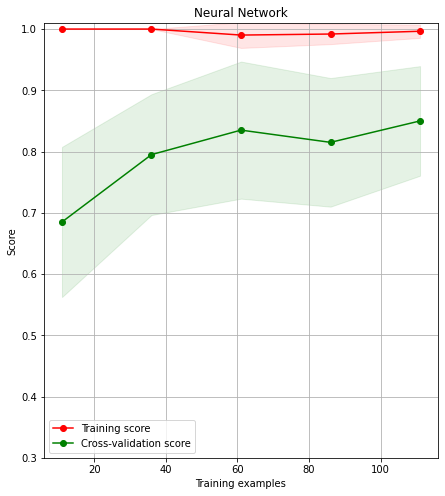

In [32]:
# Classifiers
clsfs = [MLP]

# Plot figuren
fig = plt.figure(figsize=(24,8*len(clsfs)))
  
# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

# Now use the classifiers on all datasets
num = 0
for clf in clsfs:
    # Split data in training and testing
    # title = str(type(clf))
    if hasattr(clf, 'n_estimators'):
        title = f"Random Forest Classifier, n(trees) = {clf.n_estimators}"
    elif hasattr(clf, 'C'):
        title = f"SVM Classifier, C (slack) = {clf.C}"
    elif hasattr(clf, 'n_neighbors'):
        title = f"kNN Classifier, #neighbors = {clf.n_neighbors}"
    elif hasattr(clf, 'hidden_layer_sizes'):
        title = f"Neural Network"
    ax = fig.add_subplot(len(clsfs), 3, num + 1)
    plot_learning_curve(clf, title, data_df_train, label_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1
